In [1]:
# Generic Imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,20)
pd.set_option('precision', 3)
pd.set_option('display.max_columns',50)
np.set_printoptions(precision=3)

# Project Specific Imports
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV


## Import Data

In [2]:
f_name = 'ObesityDataSet_raw_and_data_sinthetic.csv'
df = pd.read_csv(f_name, header=0)

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Data Prep

The data set attributes are as follows from the paper [found here](https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub)
<br>
<br>
Frequent consumption of high caloric food (FAVC), Frequency of consumption of vegetables (FCVC), Number of main meals (NCP), Consumption of food between meals (CAEC), Consumption of water daily (CH20), and Consumption of alcohol (CALC). The attributes related with the physical condition are: Calories consumption monitoring (SCC), Physical activity frequency (FAF), Time using technology devices (TUE), Transportation used (MTRANS), other variables obtained were: Gender, Age, Height and Weight. Finally, all data was labeled and the class variable NObesity was created with the values of: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III

In [4]:
# check for missing values
df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [6]:
# Check cardinality of categorical features
num_features = tuple(df.select_dtypes(include=['float64']).columns)
cat_features = tuple(df.select_dtypes(include=['object']).columns)
for col in cat_features:
    print(f'{col} value counts')
    print(df[col].value_counts())
    print()

Gender value counts
Male      1068
Female    1043
Name: Gender, dtype: int64

family_history_with_overweight value counts
yes    1726
no      385
Name: family_history_with_overweight, dtype: int64

FAVC value counts
yes    1866
no      245
Name: FAVC, dtype: int64

CAEC value counts
Sometimes     1765
Frequently     242
Always          53
no              51
Name: CAEC, dtype: int64

SMOKE value counts
no     2067
yes      44
Name: SMOKE, dtype: int64

SCC value counts
no     2015
yes      96
Name: SCC, dtype: int64

CALC value counts
Sometimes     1401
no             639
Frequently      70
Always           1
Name: CALC, dtype: int64

MTRANS value counts
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: MTRANS, dtype: int64

NObeyesdad value counts
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
N

### Convert Binary Vars to 0/1

In [7]:
# Gender
df['Gender'] = (df.Gender == 'Male').astype(int)

# family_history_with_overweight
df.family_history_with_overweight = (df.family_history_with_overweight == 'yes').astype(int)

# FAVC
df.FAVC = (df.FAVC == 'yes').astype(int)

# SMOKE 
df.SMOKE = (df.SMOKE == 'yes').astype(int)

# SCC
df.SCC = (df.SCC == 'yes').astype(int)

### Encode Ordinal Vars

In [8]:
ord_encoders = {}
ord_vars = ('CAEC','CALC','NObeyesdad')
ord_vals = [(('no','Sometimes','Frequently','Always'),),
           (('no','Sometimes','Frequently','Always'),),
            (('Insufficient_Weight','Normal_Weight','Overweight_Level_I',
             'Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III'),)]
for i,key in enumerate(ord_vars):
    print(key,ord_vals[i])
    ord_encoders[key] = OrdinalEncoder(categories=ord_vals[i])
    ord_encoders[key].fit(np.asarray(df[key]).reshape(-1,1))
    col = 'ord_'+key
    df[col] = ord_encoders[key].transform(np.asarray(df[key]).reshape(-1,1))


CAEC (('no', 'Sometimes', 'Frequently', 'Always'),)
CALC (('no', 'Sometimes', 'Frequently', 'Always'),)
NObeyesdad (('Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'),)


### One-Hot Encode MTRANS

In [9]:
df = pd.concat([df,pd.get_dummies(df.MTRANS).add_prefix('MTRANS_')],axis=1)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,ord_CAEC,ord_CALC,ord_NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,21.0,1.62,64.0,1,0,2.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,Public_Transportation,Normal_Weight,1.0,0.0,1.0,0,0,0,1,0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,1.0,1.0,1.0,0,0,0,1,0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,1.0,2.0,1.0,0,0,0,1,0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,Sometimes,0,2.0,0,2.0,0.0,Frequently,Walking,Overweight_Level_I,1.0,2.0,2.0,0,0,0,0,1
4,1,22.0,1.78,89.8,0,0,2.0,1.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,1.0,1.0,3.0,0,0,0,1,0


### Collect Final X vars

In [10]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'ord_CAEC', 'ord_CALC',
       'ord_NObeyesdad', 'MTRANS_Automobile', 'MTRANS_Bike',
       'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')

In [11]:
x_cols = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
          'FAVC', 'FCVC', 'NCP','SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'ord_CAEC',
          'ord_CALC','MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
          'MTRANS_Public_Transportation', 'MTRANS_Walking']
df[['ord_NObeyesdad'] + x_cols]

,ord_NObeyesdad,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,ord_CAEC,ord_CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1.0,0,21.000,1.620,64.000,1,0,2.0,3.0,0,2.000,0,0.000,1.000,1.0,0.0,0,0,0,1,0
1,1.0,0,21.000,1.520,56.000,1,0,3.0,3.0,1,3.000,1,3.000,0.000,1.0,1.0,0,0,0,1,0
2,1.0,1,23.000,1.800,77.000,1,0,2.0,3.0,0,2.000,0,2.000,1.000,1.0,2.0,0,0,0,1,0
3,2.0,1,27.000,1.800,87.000,0,0,3.0,3.0,0,2.000,0,2.000,0.000,1.0,2.0,0,0,0,0,1
4,3.0,1,22.000,1.780,89.800,0,0,2.0,1.0,0,2.000,0,0.000,0.000,1.0,1.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,6.0,0,20.977,1.711,131.409,1,1,3.0,3.0,0,1.728,0,1.676,0.906,1.0,1.0,0,0,0,1,0
2107,6.0,0,21.983,1.749,133.743,1,1,3.0,3.0,0,2.005,0,1.341,0.599,1.0,1.0,0,0,0,1,0
2108,6.0,0,22.524,1.752,133.689,1,1,3.0,3.0,0,2.054,0,1.414,0.646,1.0,1.0,0,0,0,1,0
2109,6.0,0,24.362,1.739,133.347,1,1,3.0,3.0,0,2.852,0,1.139,0.586,1.0,1.0,0,0,0,1,0


### Min Max Scale X Vars

In [12]:
scaler = MinMaxScaler()
df[x_cols] = scaler.fit_transform(df[x_cols])
df[x_cols].head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,ord_CAEC,ord_CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.0,0.149,0.321,0.187,1.0,0.0,0.5,0.667,0.0,0.5,0.0,0.000,0.5,0.333,0.000,0.0,0.0,0.0,1.0,0.0
1,0.0,0.149,0.132,0.127,1.0,0.0,1.0,0.667,1.0,1.0,1.0,1.000,0.0,0.333,0.333,0.0,0.0,0.0,1.0,0.0
2,1.0,0.191,0.660,0.284,1.0,0.0,0.5,0.667,0.0,0.5,0.0,0.667,0.5,0.333,0.667,0.0,0.0,0.0,1.0,0.0
3,1.0,0.277,0.660,0.358,0.0,0.0,1.0,0.667,0.0,0.5,0.0,0.667,0.0,0.333,0.667,0.0,0.0,0.0,0.0,1.0
4,1.0,0.170,0.623,0.379,0.0,0.0,0.5,0.000,0.0,0.5,0.0,0.000,0.0,0.333,0.333,0.0,0.0,0.0,1.0,0.0


## Test Train Split

In [13]:
X = df[x_cols]
y = df['ord_NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X Train {X_train.shape}')
print(f'X Test {X_test.shape}')
print(f'y Train {y_train.shape}')
print(f'y test {y_test.shape}')

X Train (1688, 20)
X Test (423, 20)
y Train (1688,)
y test (423,)


## EDA

In [14]:
pd.concat([y_train,X_train],axis=1).groupby('ord_NObeyesdad').mean()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,ord_CAEC,ord_CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
ord_NObeyesdad,,,,,,,,,,,,,,,,,,,,
0.0,0.375,0.123,0.456,0.082,0.458,0.819,0.742,0.635,0.005,0.425,0.074,0.412,0.404,0.488,0.187,0.181,0.000,0.000,0.792,0.028
1.0,0.511,0.167,0.422,0.171,0.538,0.733,0.673,0.581,0.049,0.436,0.116,0.416,0.327,0.508,0.228,0.151,0.004,0.027,0.698,0.120
2.0,0.509,0.199,0.455,0.265,0.739,0.932,0.630,0.492,0.009,0.549,0.111,0.363,0.288,0.319,0.296,0.218,0.009,0.004,0.735,0.034
3.0,0.637,0.284,0.478,0.321,0.929,0.758,0.631,0.506,0.021,0.511,0.017,0.312,0.350,0.358,0.207,0.329,0.000,0.004,0.646,0.021
4.0,0.546,0.256,0.457,0.398,0.982,0.967,0.597,0.480,0.022,0.547,0.004,0.322,0.327,0.350,0.186,0.322,0.000,0.007,0.663,0.007
5.0,0.992,0.308,0.607,0.570,0.996,0.975,0.692,0.583,0.054,0.427,0.004,0.317,0.262,0.338,0.259,0.339,0.004,0.000,0.653,0.004
6.0,0.004,0.202,0.448,0.610,1.000,0.996,1.000,0.667,0.004,0.602,0.000,0.225,0.306,0.335,0.332,0.004,0.000,0.000,0.996,0.000


Looks like there is some differences in mean between several of the variables by qualitative observation. 

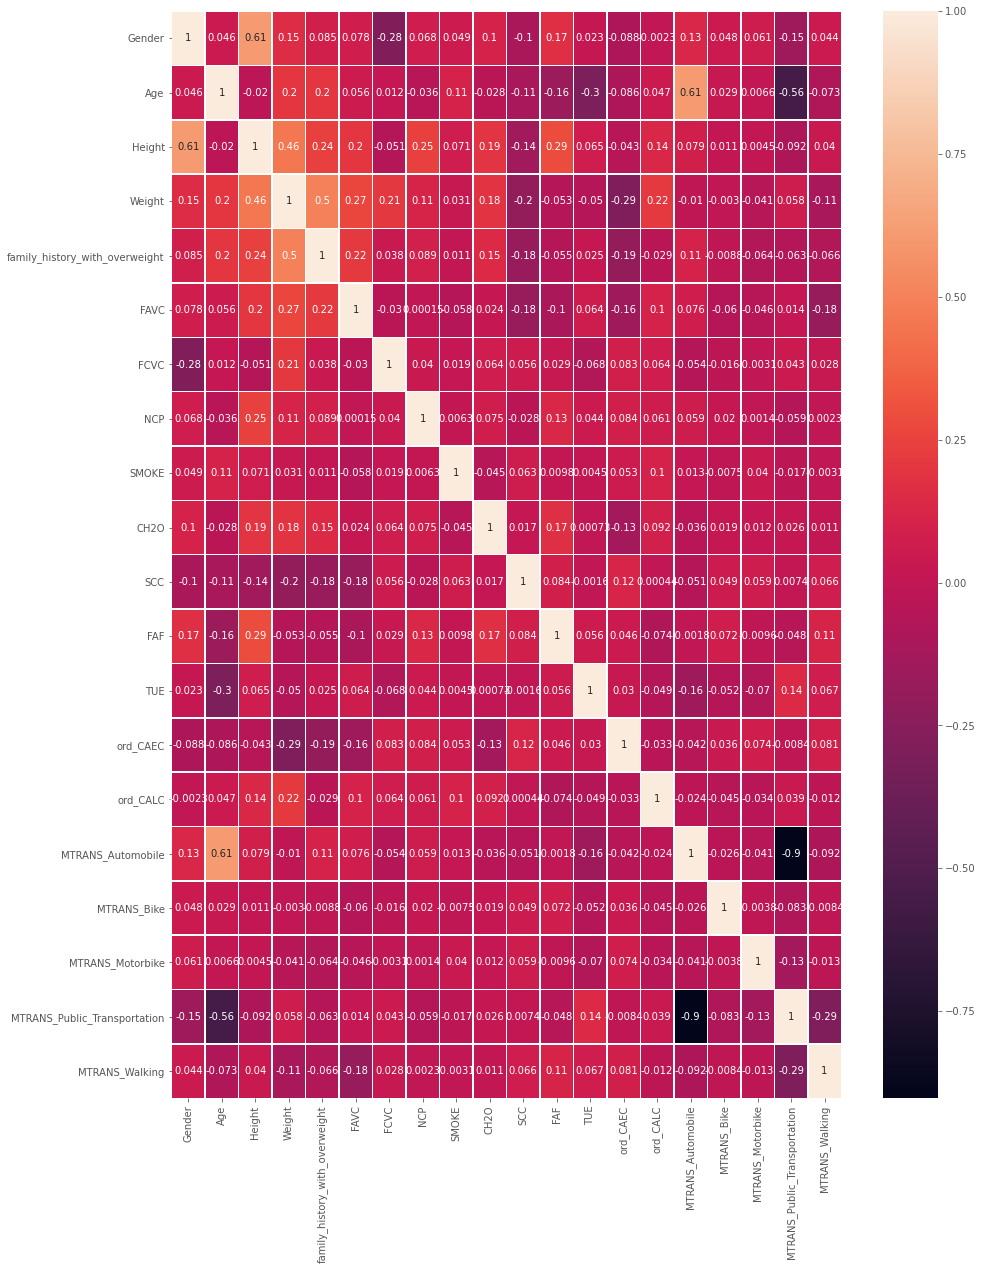

In [15]:
_=sns.heatmap(X_train.corr(), annot = True,linewidths=.5)

Some of the transportation one-hot variables are highly correlated but that is to be expected. Generally, the variables looks decoupled.

## Model Selection

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score,\
recall_score,f1_score,confusion_matrix, plot_confusion_matrix


mdls = {'lr': LogisticRegression(multi_class='ovr'),
        'svc': SVC(decision_function_shape='ovr'),
        'rf': RandomForestClassifier(n_jobs=-1),
        'xgb': XGBClassifier(n_jobs=-1),
        }

prms = {'lr': {'C': np.logspace(-4,4,9),
              'penalty': ['l1','l2']},
        'svc': {'C': np.logspace(-4,4,9)},
        'rf': {'n_estimators': [2**i for i in range(3,8)],
               'max_depth':  [8,16,32,64,None]},
        'xgb': {'min_child_weight': [4,5],
                'gamma': [i/10.0 for i in range(3,6)],
                'subsample': [i/10.0 for i in range(6,11)],
                'colsample_bytree': [i/10.0 for i in range(6,11)],
                'max_depth': [2,3,4]}
        }

#### Results
Training model: lr<br>
Fitting 5 folds for each of 18 candidates, totalling 90 fits<br>
Best Estimator: {'C': 10000.0, 'penalty': 'l2'}<br>
Best Estimator f1-score: 0.7735656783439809<br>
Training model: svc<br>
Fitting 5 folds for each of 9 candidates, totalling 45 fits<br>
Best Estimator: {'C': 1000.0}<br>
Best Estimator f1-score: 0.91378212026485<br>
Training model: rf<br>
Fitting 5 folds for each of 25 candidates, totalling 125 fits<br>
Best Estimator: {'max_depth': 64, 'n_estimators': 128}<br>
Best Estimator f1-score: 0.951265750830309<br>
Training model: xgb<br>
Fitting 5 folds for each of 450 candidates, totalling 2250 fits<br>
[22:51:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: <br>Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' <br>was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the <br>old behavior.<br>
Best Estimator: {'colsample_bytree': 0.9, 'gamma': 0.4, 'max_depth': 4, 'min_child_weight': 4, <br>'subsample': 1.0}<br>
Best Estimator f1-score: 0.9647654766964692<br>

In [17]:
# Load trained models
import joblib
best_estimators = joblib.load('best_estimators_dict.joblib')

In [31]:
evaluate = ['rf','xgb']
y_test_str = ord_encoders['NObeyesdad'].inverse_transform(np.asarray(y_test).reshape(-1,1))
for mdl in evaluate:
    y_p = ord_encoders['NObeyesdad'].inverse_transform(best_estimators[mdl].predict(X_test).reshape(-1,1))
    print('Classification Report for {}'.format(mdl))
    print(classification_report(y_test_str,y_p))
    print()

Classification Report for rf
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.96      0.98        56
      Normal_Weight       0.86      0.92      0.89        62
     Obesity_Type_I       0.99      0.95      0.97        78
    Obesity_Type_II       0.97      0.98      0.97        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.88      0.88      0.88        56
Overweight_Level_II       0.96      0.96      0.96        50

           accuracy                           0.95       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.95      0.95      0.95       423


Classification Report for xgb
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      1.00      0.96        56
      Normal_Weight       0.94      0.82      0.88        62
     Obesity_Type_I       0.99      0.96      0.97        78
    Obesity_Type_II  

## XGBoost Classifier Performs Slightly Better than RF
Examine the confusion matrix for the xgb and rf models.

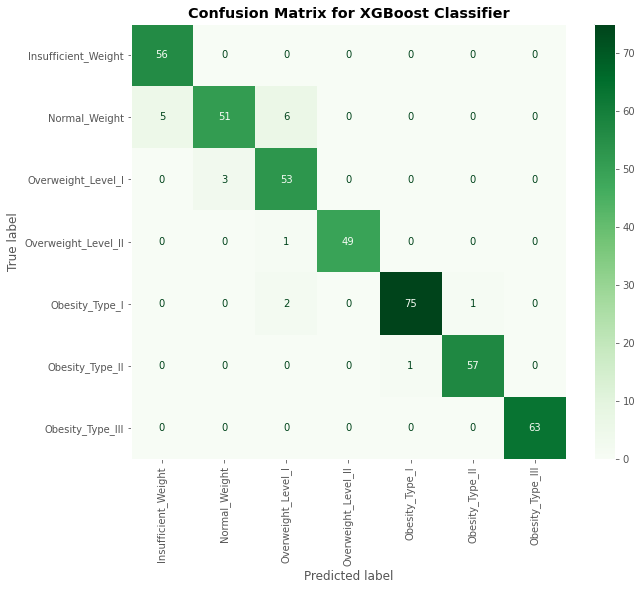

In [70]:
# Confusion Matrix
labels = list(ord_encoders['NObeyesdad'].categories_[0]) # get category labels

# plot heatmap
f,ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,8))
plot_confusion_matrix(best_estimators['xgb'],X_test,y_test,
                      xticks_rotation='vertical',display_labels=labels,
                      cmap=plt.cm.Greens, ax = ax
                     )
ax.grid(False)
_ = ax.set_title('Confusion Matrix for XGBoost Classifier',
            fontweight='bold')


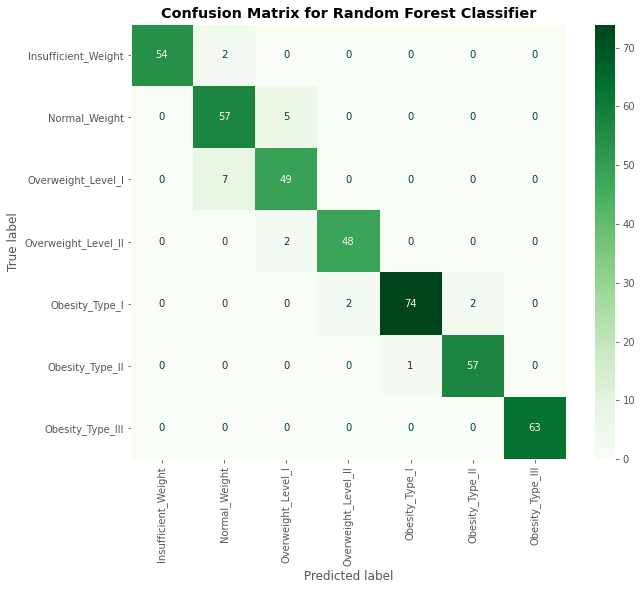

In [71]:
# plot heatmap
f,ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,8))
plot_confusion_matrix(best_estimators['rf'],X_test,y_test,
                      xticks_rotation='vertical',display_labels=labels,
                      cmap=plt.cm.Greens, ax = ax
                     )
ax.grid(False)
_ = ax.set_title('Confusion Matrix for Random Forest Classifier',
            fontweight='bold')
